In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.style as style
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import matplotlib.mlab as mlab
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression\

In [3]:
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [4]:
pred_df = pd.read_csv('b12_average_prediction.10dosages.csv')
non_pheno_pos = np.delete(np.arange(99), [82, 83, 84, 85, 86])
node_names = np.genfromtxt('../../data/node_Index.csv', delimiter = ',', dtype = np.str)[non_pheno_pos]
pred_df.shape


(438040, 6)

In [7]:
counter = 0
n_cond = 8
n_nodes = 82

n_cond = 10
n_nodes = 94

feature = pred_df.columns[-1] #'cellviab'
feature = pred_df.columns[-4] #'G1arrest'
vmin, vmax = -.8, .8

# feature = 'G2M'
# feature = 'G1arrest'
# vmin, vmax = -1, 1


n_cond_total = int(n_nodes * (n_nodes-1) /2 * n_cond**2 + n_nodes * n_cond)
pred_table = np.zeros(shape = [n_nodes, n_nodes, n_cond, n_cond])
pred_index = np.zeros(shape = [n_cond_total, 5])

for i in range(n_nodes):
    for k1 in range(n_cond):
        pred_table[i,i,k1,k1] = pred_df[feature].iloc[counter]
        pred_index[counter] = [counter, i, i, k1, k1]
        counter = counter + 1

for i in range(n_nodes):
    for j in range(i+1, n_nodes):
        for k1 in range(n_cond):
            for k2 in range(n_cond):
                pred_table[i,j,k1,k2] = pred_df[feature].iloc[counter]
                pred_table[j,i,k1,k2] = pred_df[feature].iloc[counter]
                pred_index[counter] = [counter, i, j, k1, k2]
                counter = counter + 1


pred_index = pd.DataFrame(pred_index, dtype = np.int32)

In [8]:
pred_index['cond_name'] = [node_names[pred_index.iloc[i,1]]+'_'+node_names[pred_index.iloc[i,2]]+'_'+str(pred_index.iloc[i,3])+'_'+str(pred_index.iloc[i,4]) for i in range(len(pred_index))]


In [9]:
# df = pd.read_csv('b12_average_prediction.10dosages.csv',index_col=0)
# supp = df[(pred_index[3]<5) & (pred_index[4]<5)]
# supp_index = pred_index[(pred_index[3]<5) & (pred_index[4]<5)]
# supp.index = supp_index['cond_name']
# supp.to_csv("Suppl_table_S3_predicted_response.csv")

In [10]:
cmap = sns.diverging_palette(260, 0, l=30, s=80, n=41, center="light")
n_cond = 10
n_cond_half = int(n_cond/2)

def lookup(i, j, print_ij = False):
    if (type(i)!=int):
        i = np.where(node_names == i)[0][0]
        j = np.where(node_names == j)[0][0]
    if (print_ij):
        print('Plotting: ', i, j)
    if i>j:
        t = i
        i = j
        j = t
        flag = 1
    else:
        flag = 0
    output = np.zeros([n_cond+1, n_cond+1])
    output[1:,1:] = pred_table[i,j].copy()
    output[0, 1:] = [pred_table[j, j, k ,k] for k in range(n_cond)]
    output[1:, 0] = [pred_table[i, i, k ,k] for k in range(n_cond)]

    if flag:
        output = output.transpose()
        
    return pred_df[(pred_index[1]==i)&(pred_index[2]==j)], output

In [11]:
np.where(node_names == 'c-Myc') , np.where(node_names == 'aMEK')


((array([32]),), (array([82]),))

In [13]:
cluster_np = pred_table[:, :, 0,0].copy()
for i in range(n_nodes):
    for j in range(n_nodes):
        tmp = pred_table[i,j].copy()[0:6, 0:6]
        loc = np.argmax(abs(tmp))
        cluster_np[i,j] = np.reshape(tmp,[-1])[loc]
        cluster_np[j,i] = cluster_np[i,j]    
        
cluster_pd = pd.DataFrame(cluster_np, columns = node_names, index = node_names)
cluster_pd = pd.DataFrame(cluster_np, columns = node_names, index = node_names)


/Users/cshen/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


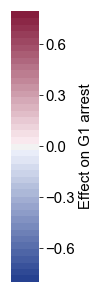

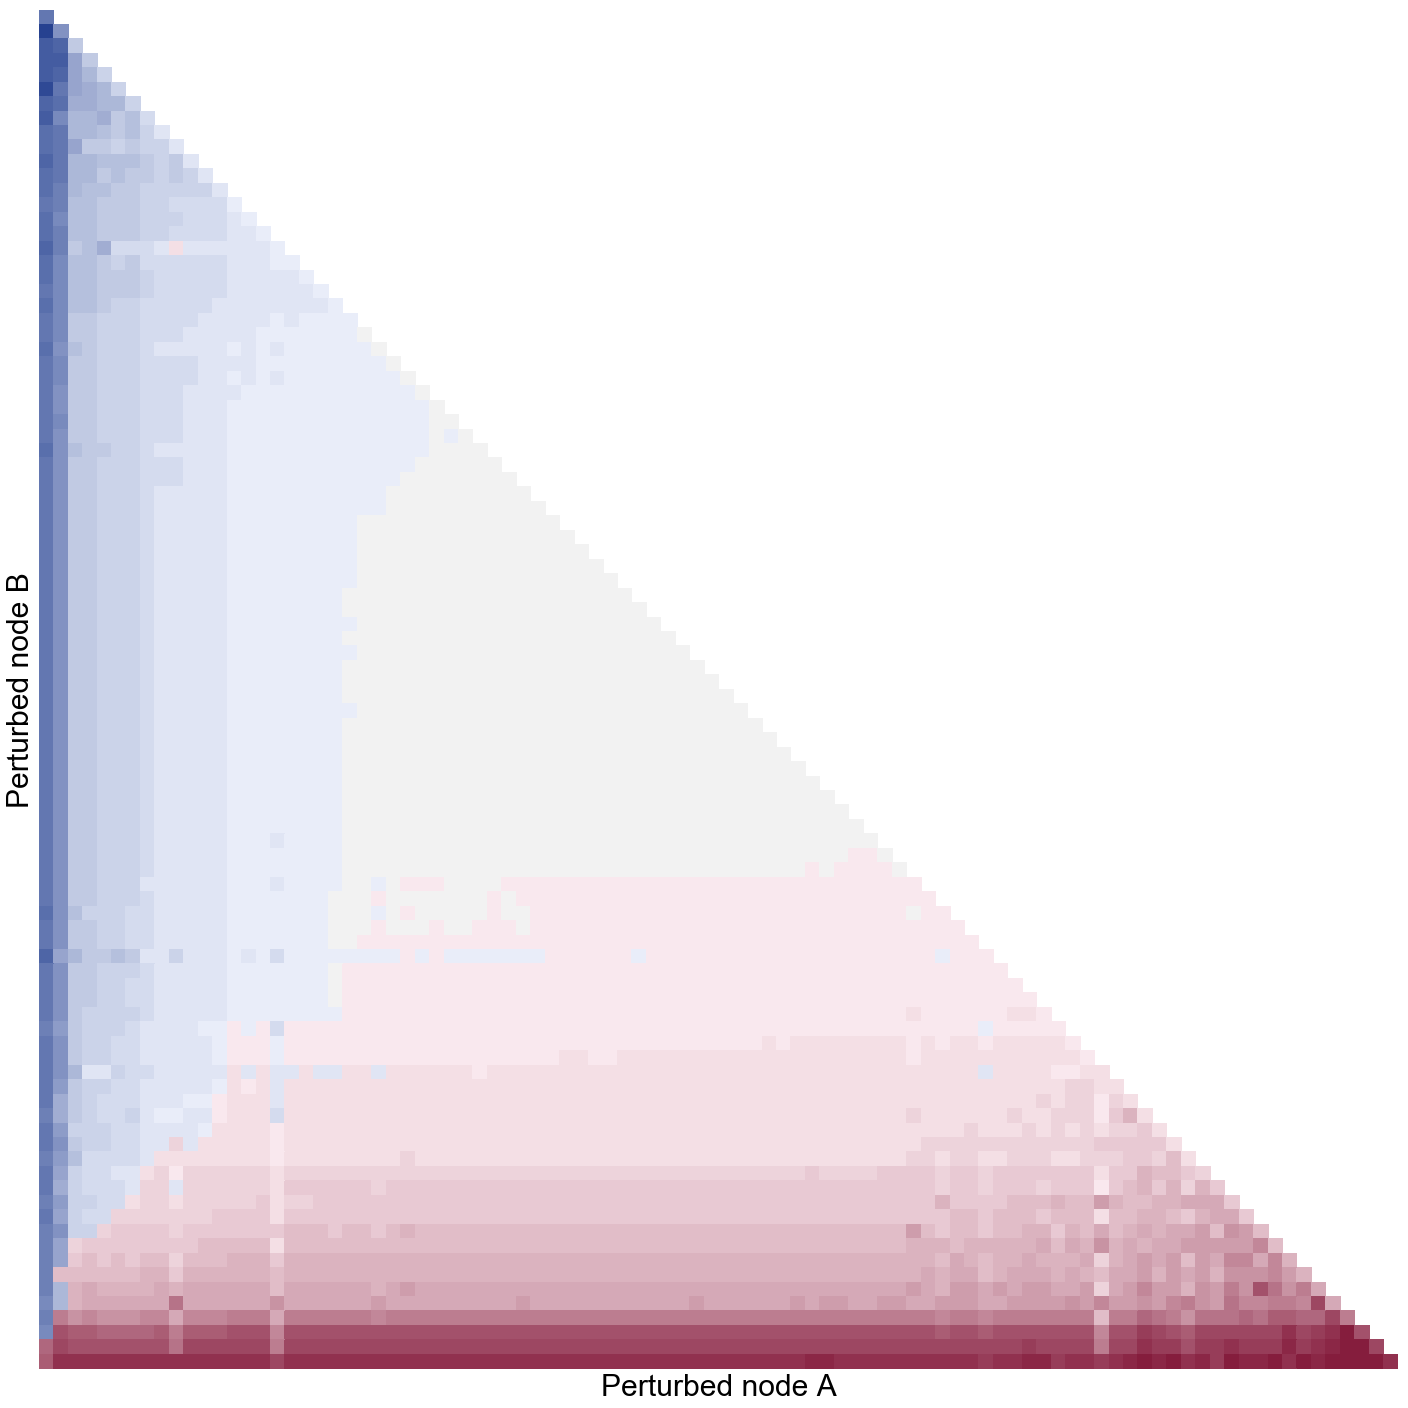

In [14]:
f_cbar, cbar_ax = plt.subplots(figsize = [0.5, 5])
f, ax = plt.subplots(figsize = [25, 25])
non_pheno_pos = np.delete(np.arange(94), [])
cluster_np2 = cluster_np[non_pheno_pos,:][:, non_pheno_pos]
ordering = np.hstack(np.argsort(np.diag(cluster_np2)))

cluster_pd = pd.DataFrame(cluster_np2[ordering,:][:, ordering], 
                          columns = node_names[ordering], index = node_names[ordering])
sns.heatmap(np.tril(cluster_pd)[0:n_nodes, 0:n_nodes], square = True, cbar_ax = cbar_ax,
            center = 0, vmin=vmin, vmax=vmax, ax = ax, cbar = True, cmap = cmap, mask=np.tril(cluster_pd)==0,
            xticklabels = False, yticklabels = False,
            cbar_kws={'label':'Effect on G1 arrest'})
#ax.set_xticklabels(node_names[ordering],size=15)
#ax.set_yticklabels(node_names[ordering],size=15)
ax.set_xlabel("Perturbed node A",size=30)
ax.set_ylabel("Perturbed node B",size=30)
cbar_ax.yaxis.label.set_size(15)
cbar_ax.tick_params(labelsize=15)
f.show()
f_cbar.show("Effect on G1 arrest")
#f.savefig("Figure6C_tril.pdf")

## Look up specific pairs

In [18]:
poi = np.array([
    ['c-Myc', 'aMEK'], 
    ['c-Myc', 'aBRAFm'], 
    ['GSK3abpS21', 'MAPKpT202'], 
    ['MEKpS217', 'b-Catenin']])


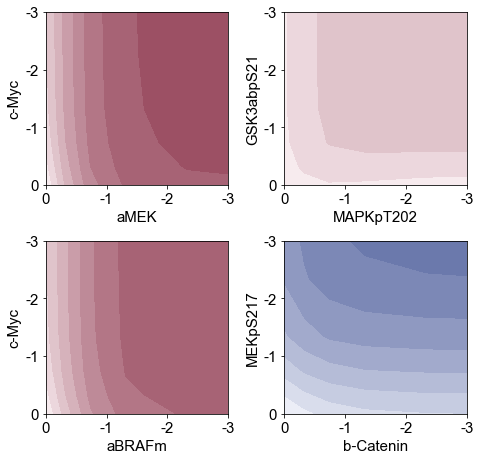

In [19]:
cmap = sns.diverging_palette(260, 0, l=35, s=60, n=41, center="light", as_cmap = True)

def lookup_plot_contour(i, j):
    data = lookup(i, j)[1]
    xs = [0, 0.2, 0.4, 0.6, 0.8, 0.9999]
    xs = [np.log(1-x)/np.log(2) for x in xs]
    xs = xs + [-3, -5, -7, -9, -11]
    xs = np.array(xs)
    order = np.argsort(xs)
    xs = -xs[order[-6:]]
    data = data[order[-6:]][:, order[-6:]]
    f = plt.contourf(xs, xs, data, 
#                      levels = [-0.8, -0.6, -0.4, -0.2, -0.1, -0.05, -0.025, -0.01, 0, 0.01, 0.025, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8],
                     levels = np.arange(-0.8,0.88,0.08), 
                     cmap=cmap, extend = 'both')
    
    if (type(i)==int):
        i = node_names[i]
        j = node_names[j]
        
    f.ax.set_xlabel(j,size=15)
    f.ax.set_ylabel(i,size=15)
    f.ax.set_xticks([0,1,2,3])
    f.ax.set_xticklabels([0,-1,-2,-3],size=15)
    f.ax.set_yticks([0,1,2,3])
    f.ax.set_yticklabels([0,-1,-2,-3],size=15)

#     f.ax.set_xticks([np.arange(0,1.2,0.25)])
#     f.ax.set_xticklabels(['0', '-25%', '-50%', '-75%', '-99%'])
#     f.ax.set_yticks(np.arange(0,1.2,0.25))
#     f.ax.set_yticklabels(['0', '-25%', '-50%', '-75%', '-99%'])

    
#     cbar = plt.colorbar(f)
#     cbar.ax.set_ylabel('Effect on G1 arrest')
#     cbar.set_ticks(np.arange(-0.8, 1, 0.4))
#     cbar.set_ticklabels(['1/4x', '1/3x', '1/2x', '1x', '1x', '2x', '3x', '4x'])


    
plt.subplots(figsize = [10, 6.5])
loc = [1,4,2,5,3,6]
for k, [i, j] in enumerate(poi):
    plt.subplot(2, 3, loc[k])
    lookup_plot_contour(i, j)

plt.tight_layout()
#plt.savefig("Figure6B.pdf",format="pdf")
# plt.savefig("figure6c.cbar.png",format="png")
